# Session 1 - Machine Learning (ML) Algorithms Introduction

This is an introductory notebook to familiarize yourself with the Google Colab environment and the data that will be used during the next two sessions of the training. For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument to test several data science techniques and machine learning algorithms.

Objectives:
- Familiarize yourself with the Google Colab environment
- Familiarize yourself with machine learning software libraries
- Introduce several basic algorithms and analyze their applicability based on the stated problem
- Introduce algorithm calls with small test data

**Author**: Jordan A. Caraballo-Vega, Caleb S. Spradlin  
**Release Date**: 2023.04.06  
**Last Modified**: 2023.04.06  

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook.

In [ ]:
!wget https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py

--2023-04-12 07:01:10--  https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6189 (6.0K) [text/plain]
Saving to: ‘folium_helper.py’

folium_helper.py    100%[===================>]   6.04K  --.-KB/s    in 0s      

2023-04-12 07:01:10 (73.0 MB/s) - ‘folium_helper.py’ saved [6189/6189]



In [ ]:
!pip install datasets optuna rasterio pyproj rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
import os
import sys
import csv
import time
import glob
import joblib
import datasets
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from rioxarray import merge
from pathlib import Path
from pprint import pprint

from huggingface_hub import snapshot_download

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# import useful packages
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import natsort

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal
import folium
from folium import plugins
import folium_helper

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

## 2. Problem Statement and Example Data Download

We will follow some of the questions included in the Model Survey from the Session 1 presentation to guide our conclusions as to which algorithm to choose given our science problem and objectives. In parallel, you should think about the science problem you want to solve, and answer the following questions accordingly so you can make this applicable to you research.

- **Which scientific question would you like to address?** We want to identify the sign, magnitude and potential drivers of change in surface water extent in X study area.

- **What information is missing to answer this question?** We need surface water extent maps to quantify and analyze these drivers.

- **What data do you have available?** We have global coverage with data from the MODIS satellite.

- **Do you have training data available?** We have gathered large extents of training data points.

- **What is the data structure of your data?** Our data is in raster format, we can preprocess it to make it tabular.

- **Is your dependent variable a continuous or discrete problem?** Our dependent variable are water pixels, which is discrete (0 – no water, 1 – water)

- **Are there any performance requirements based on your science question? (e.g. real time vs static)** We do not need real time maps (e.g. disaster response teams might need them).

- **Is your software going to run on on-premise, cloud, or embedded hardware?** We want our software to run both on-premise and in the cloud.

- **What is more important for your project: inference time or model performance?** We care more about model performance than inference time.

## 3. What information is missing to answer this question? What data do you have available?

We need surface water extent maps to quantify and analyze these drivers. We have access to the entire MODIS data collection, thus we are not limited in regards to data.

Now, here we start thinking how to approach the problem. There are many ways to think about it, thus we can think assesing what information we would need. Some examples are:

- Is this a classification or a regression problem? Since we want to map water, we can make this a classification problem. This excludes some algorithms like Random Forest Regressor, etc. If we were trying to get water depth, then we would change our focus of the algorithm.

- Do we want to have multiple water classes? (e.g. open waters, rivers, oceans, etc.) No, we want to map water as a general class, thus we can stick with a simple binary classification problem. If we wanted to have multiple water classes we would need to go to the multiclass route, and use techniques such as multiclass segmentation, and/or object detection.

![image](https://lpdaac.usgs.gov/media/images/MOD44W_V006_01Jan2015_GreatLakes_Hero.original_Actjmp6.jpg)

## 4. Do you have training data available?

This is always one of the main questions in any machine learning problem, and it is of extreme importance to answer it early in the development workflow. Dependening on the availability of the training data, the selection of our model might be limited.

For example, a Random Forest model might not need as many observations as a Convolutional Neural Network. Thus, the amount of training data available can play a big role.

We can always work on feature engineering techniques to increase our training size, but there are always limitations we need to be aware of. Which then brings additional questions:

- Is our training data of good quality? This would be really important depending on your application. Disaster responding applications might not be flexible enough to have misslabeled data in their training since it might bring additional noise to their models. Someone dealing with other types of simple classification problems might not be that worried about having some misslabeled data on their training dataset. Thus the required quality will be depedent on the problem.

- Is there any labeled data out there I could reuse? There could be cross domain labels that might be useful for your own application.

- How much budget do you have to spend in labeling data? If your budget is limited, you might need to stick with unsupervised or self-supervised applications that do not require you to have large extents of training data.



You could even use a combination of techniques between unsupervised and supervised learning. For example, here we will perform unsupervised clustering using the K-means algorithm an see if we can extract some water masks out of it.

### 4.1 Data download

The first step is to download some imagery to test with.

In [ ]:
powell_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.tif", repo_type='dataset')

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
fileList = sorted([file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'sur_refl' in file])

In [ ]:
raster_arrays = []
for val in fileList:
    raster_arrays.append(rxr.open_rasterio(val))

raster = xr.concat(raster_arrays, dim="band")
raster

<xarray.DataArray (band: 7, y: 1300, x: 1300)>
array([[[1547, 1474, 1474, ..., 3151, 3151, 3087],
        [1395, 1395, 1379, ..., 3323, 3323, 3148],
        [1408, 1403, 1379, ..., 3223, 3223, 3203],
        ...,
        [2196, 2186, 2255, ..., 2193, 2253, 2230],
        [2186, 2255, 2341, ..., 2154, 2235, 2217],
        [2320, 2439, 2169, ..., 2358, 2425, 2402]],

       [[2461, 2377, 2377, ..., 4079, 4079, 4081],
        [2340, 2340, 2365, ..., 4276, 4276, 4170],
        [2343, 2387, 2365, ..., 4206, 4206, 4153],
        ...,
        [3175, 3132, 3207, ..., 2858, 2858, 2820],
        [3132, 3207, 3310, ..., 2776, 2853, 2854],
        [3284, 3392, 3113, ..., 2979, 3069, 3038]],

       [[ 857,  857,  846, ..., 1669, 1565, 1565],
        [ 857,  857,  846, ..., 1669, 1565, 1565],
        [ 812,  812,  822, ..., 1565, 1565, 1565],
        ...,
...
        ...,
        [4066, 4066, 4012, ..., 3650, 3672, 3672],
        [3981, 3981, 3951, ..., 3633, 3747, 3747],
        [3981, 3981, 3951, ..., 3633, 3747, 3747]],

       [[2730, 2730, 2613, ..., 5380, 5259, 5259],
        [2730, 2730, 2613, ..., 5380, 5259, 5259],
        [2587, 2587, 2592, ..., 5259, 5259, 5259],
        ...,
        [4343, 4343, 4330, ..., 4266, 4247, 4247],
        [4235, 4235, 4235, ..., 4223, 4345, 4345],
        [4235, 4235, 4235, ..., 4223, 4345, 4345]],

       [[2222, 2222, 2098, ..., 4809, 4576, 4576],
        [2222, 2222, 2098, ..., 4809, 4576, 4576],
        [2075, 2075, 2117, ..., 4576, 4576, 4576],
        ...,
        [3826, 3826, 3766, ..., 3862, 3863, 3863],
        [3694, 3694, 3739, ..., 3863, 3919, 3919],
        [3694, 3694, 3739, ..., 3863, 3919, 3919]]], dtype=int16)
Coordinates:
  * band         (band) int64 1 1 1 1 1 1 1
  * x            (x) float64 -1.005e+07 -1.005e+07 ... -9.753e+06 -9.753e+06
  * y            (y) float64 4.61e+06 4.61e+06 4.609e+06 ... 4.309e+06 4.309e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0

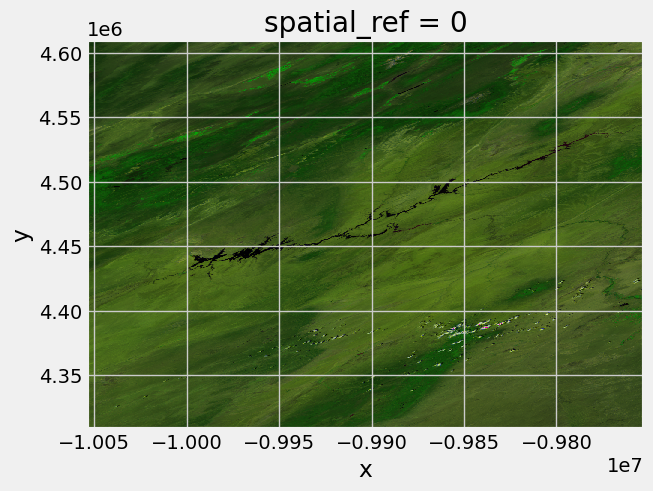

In [ ]:
(raster[:3, :, :] / 10000).plot.imshow()

## 4.2 K-means clustering

The K-Means algorithm splits the given dataset into a predefined (K) number of clusters using the Euclidean Distance. The center of each cluster/group is called the centroid.

- Initially, a K number of centroids is chosen (there are different methods for selecting the right value for K).
- We then shuffle the data and initialize centroids—randomly select K data points for centroids without replacement.
- Create new centroids by calculating the mean value of all the samples assigned to each previous centroid.
- Randomly initialize the centroid until there’s no change in the centroid, so the assignment of data points to the cluster isn’t changing.

![image](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/K-means-clustering.png?ssl=1)

There are many clustering algorithms out there, but the core concept is the calculation of a distance metric that can create invidividual groups of data. Sometimes these clustering techniques can be enough to perform classification on your data, sometimes the patterns on your data can be complex enough for clustering algorithms to not pick slight variations.

In [ ]:
# number of clusters
N_CLUSTERS = 4

# grab the number of bands in the image, naip images have four bands
nbands = raster.shape[0]

# create an empty array in which each column will hold a flattened band
flat_data = np.empty((raster.shape[1]*raster.shape[2], nbands))

# loop through each band in the image and add to the data array
for i in range(nbands):
    band = raster[i,:,:].values
    flat_data[:, i-1] = band.flatten()

# set up the kmeans classification by specifying the number of clusters 
km = KMeans(n_clusters=N_CLUSTERS)

# begin iteratively computing the position of the two clusters
km.fit(flat_data)

KMeans(n_clusters=4)

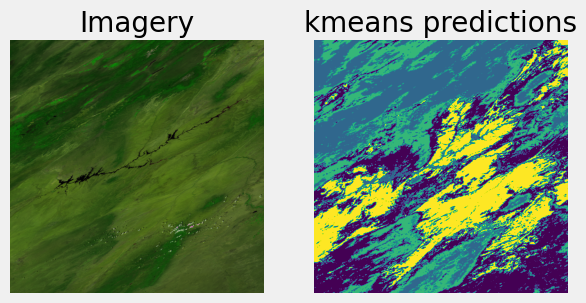

In [ ]:
# use the sklearn kmeans .predict method to assign all the pixels of an image to a unique cluster
flat_predictions = km.predict(flat_data)

# rehsape the flattened precition array into an MxN prediction mask
prediction_mask = flat_predictions.reshape((raster.shape[1], raster.shape[2]))

# plot the imagery and the prediction mask for comparison
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.moveaxis(raster[:3,:,:].values, 0, -1) / 10000)
axarr[0].set_title('Imagery')
axarr[1].imshow(prediction_mask)
axarr[1].set_title('kmeans predictions')

axarr[0].axis('off')
axarr[1].axis('off')

plt.show()

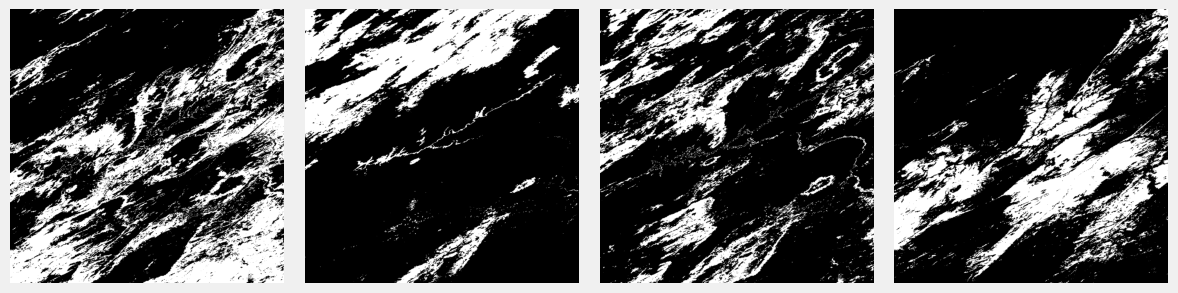

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(12, 12))
for n, ax in enumerate(axes.flatten()):
    ax.imshow(prediction_mask==[n], cmap='gray');
    ax.set_axis_off()
    
fig.tight_layout()

We could create several clusters and aggregate them manually until we get the water pixels we are interest on. While this might be feasable for some tiles, we need to scale this to map World water extent, which becomes impossible to do as a manual process.

## 5. What is the data structure of your data?

Depending on the format of our data, we can choose between several machine learning algorithms. For example, we can convert a raster into tabular format easily like we did above.

Spatially aware models like Convolutional Neural Networks often require continuous pixels in order to perform additional spatial pattern discovery. Algorithms like Random Forest and XGBoost that only rely on the values per feature, can be trained simply from point observations, which are oftentimes cheaper to get.

### Random Forest

Let's introduce the basics of a Random Forest here. We have a set N of observations where our target variable is a pixel whose possible outcomes are water or not-water. From here we create a set of independent trees looking at folds of the data that then take a decision by majority voting for classification, or by average when dealing with regression problems. This random generation of the dataset is called bootstrapping. 

![image](https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif)

The Random Forest can oftentimes work on small dataset, but it will be highly dependant on the representativeness of the training data, with high variance to unseen samples.

```python
from sklearn.ensemble import RandomForestClassifier
# create model instance
rf = RandomForestClassifier()
# fit model
rf.fit(X_train, y_train)
# make predictions
preds = rf.predict(X_test)
```

### XGBoost

To improve upon the high variance of the Random Forest, the Extreme Gradient Boosting (XGBoost) algorithm was developed. This algorithm takes the Random Forest structure even further by prioritizing the training of the model into improving on missclassified samples. 

![image](https://dz2cdn1.dzone.com/storage/temp/13069527-boosting-algo.png)

The use of the Gradient Descent algorithm can be simply explained by the strategy of minimizing the cost function, or the error between predicted and actual y in this case, by means of iterations and optimization steps. XGBoost also uses regularization techniques that can help to avoid overfitting when compared to the Random Forest.

![image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*QJZ6W-Pck_W7RlIDwUIN9Q.jpeg)

```python
from xgboost import XGBClassifier
# create model instance
bst = XGBClassifier(
  n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)
```

### Neural Networks

Further up in the complexity realm we have Neural Networks. These are the base for deep learning algorithms and their main focus is on the mimicking of the human brain. The main idea behind Neural Networks is the use of connected neurons that can transmit information and be strictly activated based on a threshold that is normally defined by an activation function.

As opposed to the tree ensembles we described above, neural networks use forward and back propagation to learn. Thus no trees are built and it makes them capable of extracting patterns out of the data without stricly performing feature engineering like the ones needed by trees.

The downside is that given this feature extraction process, neural networks need substantially more training data when compared to the tree ensemble algorithms.

![image](https://cdn-images-1.medium.com/max/1024/1*CniSdF4zewDrajSHwCekSQ.gif)

```python
import tensorflow as tf
# create model instance
nn = keras.Sequential([
    keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(28, 28)),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=192, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax')
])

# compile model instance - extra step when compared to trees
model.compile(optimizer='adam', 
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# fit model
nn.fit(
    (X_train, y_train), 
    epochs=10, 
    steps_per_epoch=500,
    validation_data=(X_val, y_val), 
    validation_steps=2
)

# make predictions
preds = nn.predict(X_test)
```

### Convolutional Neural Networks

All of the algorithms previously discussed work really well with structured data (tabular format), and Neural Networks normally with both structured and unstructured data. However, none of them take into account spatial features when trying to learn from the data.

Convolutional Neural Networks (CNNs) take the learning a step further by learning features from both the individual pixels, but their neighboring pixels as well. Using the same forward and backward propagation methods, CNNs can use sliding windows to extract information around local neighbornhoods around pixels.

These have proven to be extremely powerful in segmentation tasks, and have proven to be capable of also outputing continuous values by performing additional modifications to their networks.

![image](https://www.mobiquity.com/hs-fs/hubfs/CNN03.gif?width=640&name=CNN03.gif)

The challenge behind CNNs and Neural Networks is their need for large extents of training data and performance when compared to other algorithms like tree ensembles.

## Closing Thoughts

- We have discussed ways of generating additional training data that might save some time in the overall process
- We have discussed the basics of several algorithms commonly used in Earth Science
- We have provided the base to understand which algorithm might be useful depending on the problem
- We have discussed techniques to better choose the initial algorithm to test, making it clear that you can always change the algorithm without major changes in your code